In [1]:
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_style('whitegrid',{'grid.color':'0.95'})
import matplotlib.dates as mdates
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm 
import statsmodels.tsa.api as smt

from tabulate import tabulate
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as abg
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR

In [2]:
poe5csv='http://www.principlesofeconometrics.com/poe5/data/csv/'
gdp=pd.read_csv(poe5csv+'gdp.csv')
print(gdp.head(3),'\n')
print(gdp.tail(3))

       usa      aus
0  38.3011  38.2355
1  38.3734  38.7551
2  38.7137  38.7706 

         usa       aus
121  100.315  100.4380
122  100.200  100.6040
123  100.721   99.6807


In [3]:
gdp['qtr']=pd.period_range(start=pd.Period('1970Q1',freq='Q'),
                           end=pd.Period('2000Q4',freq='Q'))
gdp['year']=gdp['qtr'].dt.year
gdp['quarter']=gdp['qtr'].dt.quarter
n=len(gdp.index)
s=[]
for i in range(n):
    val1=str(gdp.year.iloc[i])+'Q'+str(gdp.quarter.iloc[i])
    s.append(val1)
gdp['qtr_str']=s
gdp=gdp.set_index(gdp.qtr_str)
print(gdp[['usa','aus']].head(3),'\n')
print(gdp[['usa','aus']].tail(3),'\n')

             usa      aus
qtr_str                  
1970Q1   38.3011  38.2355
1970Q2   38.3734  38.7551
1970Q3   38.7137  38.7706 

             usa       aus
qtr_str                   
2000Q2   100.315  100.4380
2000Q3   100.200  100.6040
2000Q4   100.721   99.6807 



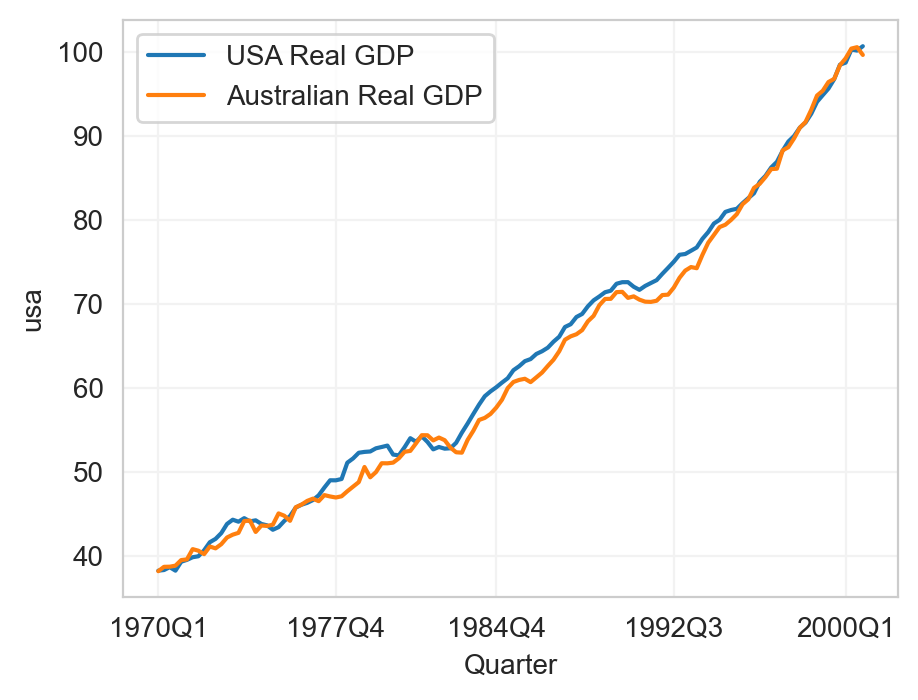

In [4]:
ax1=sns.lineplot(x=gdp.index,y=gdp.usa,label='USA Real GDP')
ax2=sns.lineplot(x=gdp.index,y=gdp.aus,label='Australian Real GDP')
ax1.set(xlabel='Quarter')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))     
plt.legend();

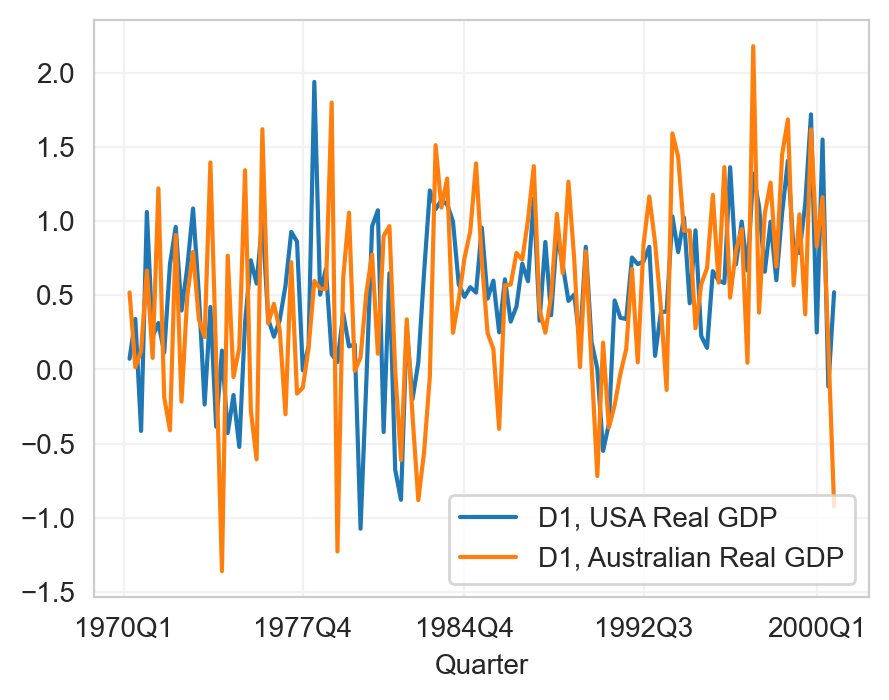

In [5]:
gdp['D1usa']=gdp.usa.diff(1)
gdp['D1aus']=gdp.aus.diff(1)
ax1=sns.lineplot(x=gdp.index,y=gdp.D1usa,label='D1, USA Real GDP')
ax2=sns.lineplot(x=gdp.index,y=gdp.D1aus,label='D1, Australian Real GDP')
ax1.set(xlabel='Quarter',ylabel='')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))     
plt.legend();

In [6]:
adf=ADF(gdp.aus,lags=1)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                  2.658
P-value                         0.999
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [7]:
adf=ADF(gdp.usa,lags=3)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                  1.691
P-value                         0.998
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [8]:
res=smf.ols(formula='aus~usa-1',data=gdp).fit()
print(res.summary().tables[1])
gdp['ehat']=res.resid

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
usa            0.9853      0.002    594.787      0.000       0.982       0.989


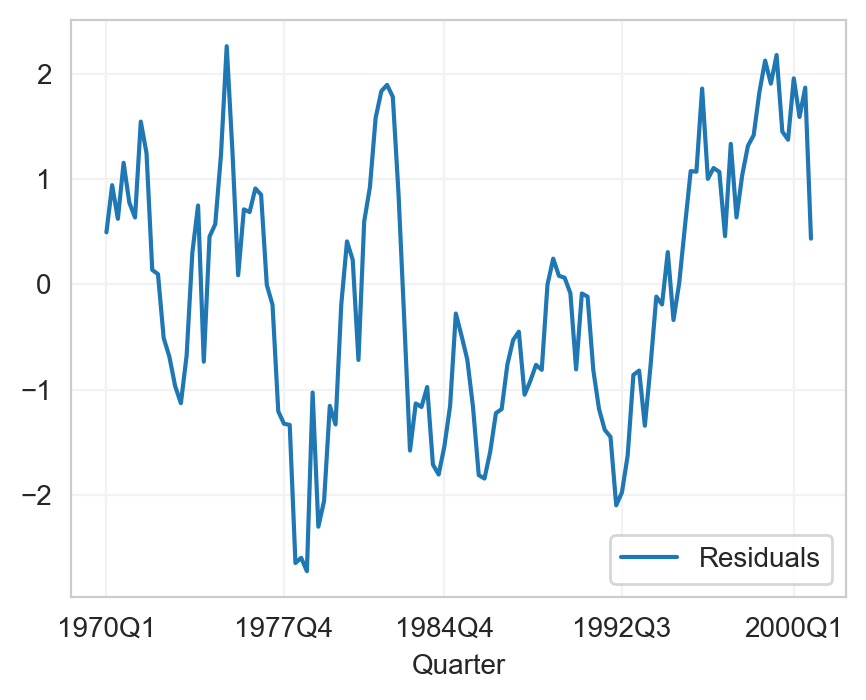

In [9]:
ax1=sns.lineplot(x=gdp.index,y=gdp.ehat,label='Residuals')
ax1.set(xlabel='Quarter',ylabel='')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))     

In [10]:
gdp['D1ehat']=gdp.ehat.diff(1)
gdp['L1ehat']=gdp.ehat.shift(1)
res=smf.ols(formula='D1ehat~L1ehat-1',data=gdp).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
L1ehat        -0.1279      0.044     -2.889      0.005      -0.216      -0.040


In [11]:
res=smf.ols(formula='D1aus~L1ehat',data=gdp).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4917      0.058      8.491      0.000       0.377       0.606
L1ehat        -0.0987      0.048     -2.077      0.040      -0.193      -0.005


In [12]:
res=smf.ols(formula='D1usa~L1ehat',data=gdp).fit()
print(res.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5099      0.047     10.924      0.000       0.417       0.602
L1ehat         0.0303      0.038      0.790      0.431      -0.046       0.106


In [13]:
fred=pd.read_csv(poe5csv+'fred5.csv')
fred['dateid01']=pd.to_datetime(fred['dateid01'],format='%m/%d/%Y')
fred['qtr']=pd.PeriodIndex(fred.dateid01,freq='Q')
fred['year']=fred['dateid01'].dt.year
fred['quarter']=fred['dateid01'].dt.quarter
n=len(fred.index)
s=[]
for i in range(n):
    val1=str(fred.year.iloc[i])+'Q'+str(fred.quarter.iloc[i])
    s.append(val1)
fred['qtr_str']=s
fred=fred.set_index(fred.qtr_str)
print(fred[['dateid01','consn','y']].head(3))

          dateid01    consn         y
qtr_str                              
1986Q1  1986-01-01  8.50098  8.632199
1986Q2  1986-04-01  8.51210  8.645393
1986Q3  1986-07-01  8.53005  8.652441


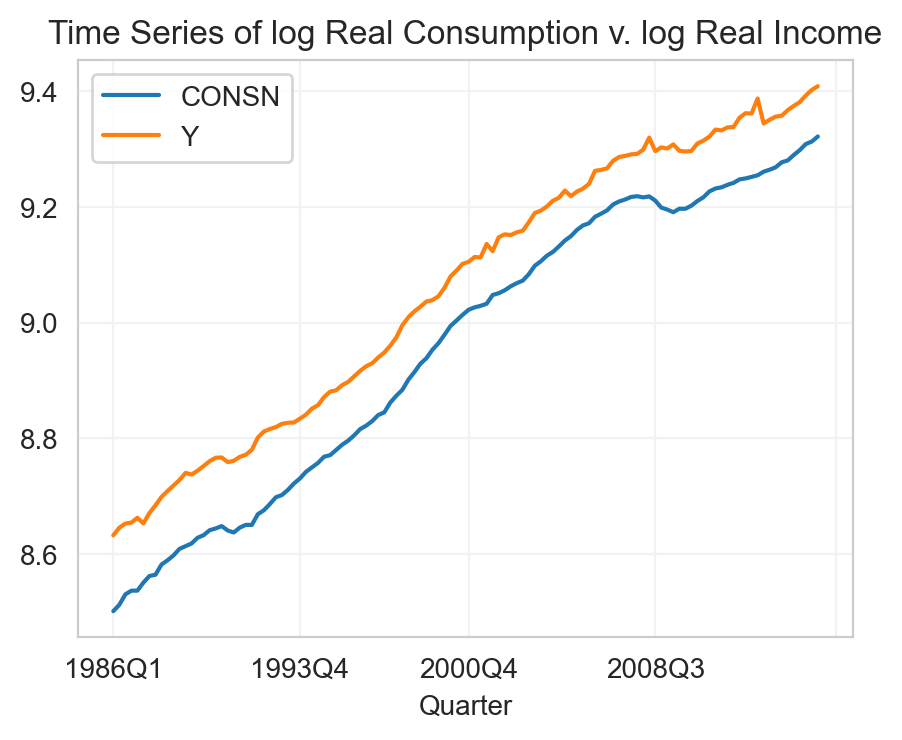

In [14]:
ax1=sns.lineplot(x=fred.index,y=fred.consn,label='CONSN')
ax2=sns.lineplot(x=fred.index,y=fred.y,label='Y')
ax1.set(xlabel='Quarter',ylabel='')
plt.title('Time Series of log Real Consumption v. log Real Income')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))     
plt.legend();

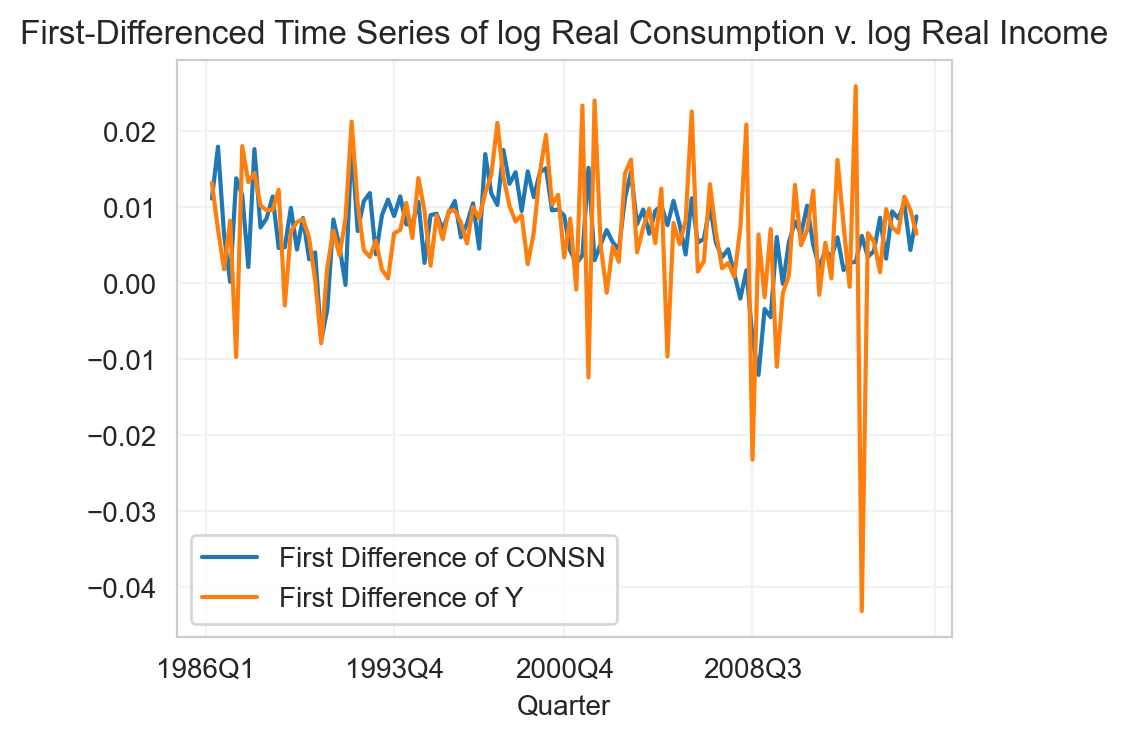

In [15]:
fred['D1consn']=fred.consn.diff(1)
fred['D1y']=fred.y.diff(1)
ax1=sns.lineplot(x=fred.index,y=fred.D1consn,
                 label='First Difference of CONSN')
ax2=sns.lineplot(x=fred.index,y=fred.D1y,
                 label='First Difference of Y')
ax1.set(xlabel='Quarter',ylabel='')
plt.title('First-Differenced Time Series of log Real Consumption v. log Real Income')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.legend();

In [16]:
fred['D1consn']=fred.consn.diff(1)
fred['D1L1consn']=fred.consn.diff(1).shift(1)
fred['L1consn']=fred.consn.shift(1)
res=smf.ols(formula='D1consn~L1consn+D1L1consn',data=fred).fit()
head=['lags (p)','chi2','df','Prob > chi2']
table=[[1,abg(res,nlags=1)[0],1,round(abg(res,nlags=1)[1],3)],   
       [2,abg(res,nlags=2)[0],2,round(abg(res,nlags=2)[1],3)],
       [3,abg(res,nlags=3)[0],3,round(abg(res,nlags=3)[1],3)],
      ]
print('Breusch-Godfrey LM Test for Autocorrelation (differenced-lag = 1):')
print(tabulate(table,headers=head,floatfmt='.3f',
               colalign=('center','decimal','center','center'),
              )
     )
print('H0: no serial correlation')

Breusch-Godfrey LM Test for Autocorrelation (differenced-lag = 1):
 lags (p)     chi2   df    Prob > chi2
----------  ------  ----  -------------
    1        8.586   1        0.003
    2       22.085   2        0.000
    3       23.762   3        0.000
H0: no serial correlation


In [17]:
fred['D1L2consn']=fred.consn.diff(1).shift(2)
res=smf.ols(formula='D1consn~L1consn+D1L1consn+D1L2consn',
            data=fred).fit()
table=[[1,abg(res,nlags=1)[0],1,round(abg(res,nlags=1)[1],3)],   
       [2,abg(res,nlags=2)[0],2,round(abg(res,nlags=2)[1],3)],
       [3,abg(res,nlags=3)[0],3,round(abg(res,nlags=3)[1],3)],
      ]
print('Breusch-Godfrey LM Test for Autocorrelation (differenced-lag = 2):')
print(tabulate(table,headers=head,floatfmt='.3f',
               colalign=('center','decimal','center','center'),
              )
     )
print('H0: no serial correlation')

Breusch-Godfrey LM Test for Autocorrelation (differenced-lag = 2):
 lags (p)     chi2   df    Prob > chi2
----------  ------  ----  -------------
    1        6.421   1        0.011
    2        7.431   2        0.024
    3       16.670   3        0.001
H0: no serial correlation


In [18]:
fred['D1L3consn']=fred.consn.diff(1).shift(3)
res=smf.ols(formula='D1consn~L1consn+D1L1consn+D1L2consn+D1L3consn'
            ,data=fred).fit()
table=[[1,abg(res,nlags=1)[0],1,round(abg(res,nlags=1)[1],3)],   
       [2,abg(res,nlags=2)[0],2,round(abg(res,nlags=2)[1],3)],
       [3,abg(res,nlags=3)[0],3,round(abg(res,nlags=3)[1],3)],
      ]
print('Breusch-Godfrey LM Test for Autocorrelation (differenced-lag = 3):')
print(tabulate(table,headers=head,floatfmt='.3f',
               colalign=('center','decimal','center','center'),
              )
     )
print('H0: no serial correlation')

Breusch-Godfrey LM Test for Autocorrelation (differenced-lag = 3):
 lags (p)     chi2   df    Prob > chi2
----------  ------  ----  -------------
    1        0.834   1        0.361
    2        7.224   2        0.027
    3        7.257   3        0.064
H0: no serial correlation


In [19]:
adf=ADF(fred.consn,lags=3,trend='c')
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.875
P-value                         0.796
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [20]:
adf=ADF(fred.consn,lags=3,trend='ct')
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.633
P-value                         0.779
Lags                                3
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [21]:
fred['cons']=1
fred['L1y']=fred.y.shift(1)
for i in range(1,4):
    fred['D1L'+str(i)+'y']=fred.y.diff(1).shift(i)
df=fred[['D1y','cons','L1y','D1L1y','D1L2y','D1L3y']]
for i,j in zip(range(2,5),range(4,8)):
    res=sm.OLS(df.iloc[i:,0:1],df.iloc[i:,1:j]).fit()
    table=[
        [1,abg(res,nlags=1)[0],1,round(abg(res,nlags=1)[1],3)],
        [2,abg(res,nlags=2)[0],2,round(abg(res,nlags=2)[1],3)],
        [3,abg(res,nlags=3)[0],3,round(abg(res,nlags=3)[1],3)],
    ]
    print(f'Breusch-Godfrey LM Test for Autocorrelation (lags = {str(i-1)}):')
    print(tabulate(table,headers=head,floatfmt='.3f',
                   colalign=('center','decimal','center','center'),
                  )
         )
    print('H0: no serial correlation \n')

Breusch-Godfrey LM Test for Autocorrelation (lags = 1):
 lags (p)     chi2   df    Prob > chi2
----------  ------  ----  -------------
    1        1.151   1        0.283
    2        1.558   2        0.459
    3        1.586   3        0.663
H0: no serial correlation 

Breusch-Godfrey LM Test for Autocorrelation (lags = 2):
 lags (p)     chi2   df    Prob > chi2
----------  ------  ----  -------------
    1        0.346   1        0.557
    2        2.187   2        0.335
    3        2.199   3        0.532
H0: no serial correlation 

Breusch-Godfrey LM Test for Autocorrelation (lags = 3):
 lags (p)     chi2   df    Prob > chi2
----------  ------  ----  -------------
    1        0.156   1        0.693
    2        0.541   2        0.763
    3        1.176   3        0.759
H0: no serial correlation 



In [22]:
adf=ADF(fred.y,lags=1,trend='c')
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.653
P-value                         0.455
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [23]:
adf=ADF(fred.y,lags=1,trend='ct')
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.427
P-value                         0.986
Lags                                1
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.04 (1%), -3.45 (5%), -3.15 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [24]:
res=smf.ols(formula='consn~y',data=fred).fit()
fred['ehat']=res.resid
fred['D1ehat']=fred.ehat.diff(1)
fred['D1L1ehat']=fred.ehat.diff(1).shift(1)
fred['L1ehat']=fred.ehat.shift(1)
res=smf.ols(formula='D1ehat~D1L1ehat+L1ehat-1',data=fred).fit()
print(f'Test Statistic for Cointegration Residuals: {round(res.params.iloc[1]
                                                           /res.bse.iloc[1],4)}')

Test Statistic for Cointegration Residuals: -3.0458


In [25]:
model=VAR(fred[['D1consn','D1y']],freq='QS-OCT',missing='drop')
res1=model.fit(maxlags=1)
print(res1.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Jun, 2025
Time:                     09:27:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -20.2021
Nobs:                     116.000    HQIC:                  -20.2867
Log likelihood:           856.789    FPE:                1.46046e-09
AIC:                     -20.3445    Det(Omega_mle):     1.38775e-09
--------------------------------------------------------------------
Results for equation D1consn
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.003671         0.000753            4.873           0.000
L1.D1consn         0.348192         0.086589            4.021           0.000
L1.D1y             0.131345         0.052067            2.523         

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)


In [26]:
var_ord=model.select_order(maxlags=5)
print(var_ord.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -20.07      -20.02   1.930e-09      -20.05
1      -20.42     -20.27*   1.361e-09      -20.36
2      -20.44      -20.20   1.327e-09      -20.34
3      -20.52      -20.18   1.224e-09     -20.38*
4     -20.52*      -20.09  1.220e-09*      -20.35
5      -20.46      -19.93   1.299e-09      -20.25
-------------------------------------------------


In [27]:
res=VAR(fred[['D1consn','D1y']],missing='drop',freq='QS-OCT').fit(maxlags=4)  
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 18, Jun, 2025
Time:                     09:27:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -20.0559
Nobs:                     113.000    HQIC:                  -20.3140
Log likelihood:           855.024    FPE:                1.26315e-09
AIC:                     -20.4903    Det(Omega_mle):     1.08366e-09
--------------------------------------------------------------------
Results for equation D1consn
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.002320         0.000813            2.854           0.004
L1.D1consn         0.198084         0.095802            2.068           0.039
L1.D1y             0.072949         0.050199            1.453         

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)


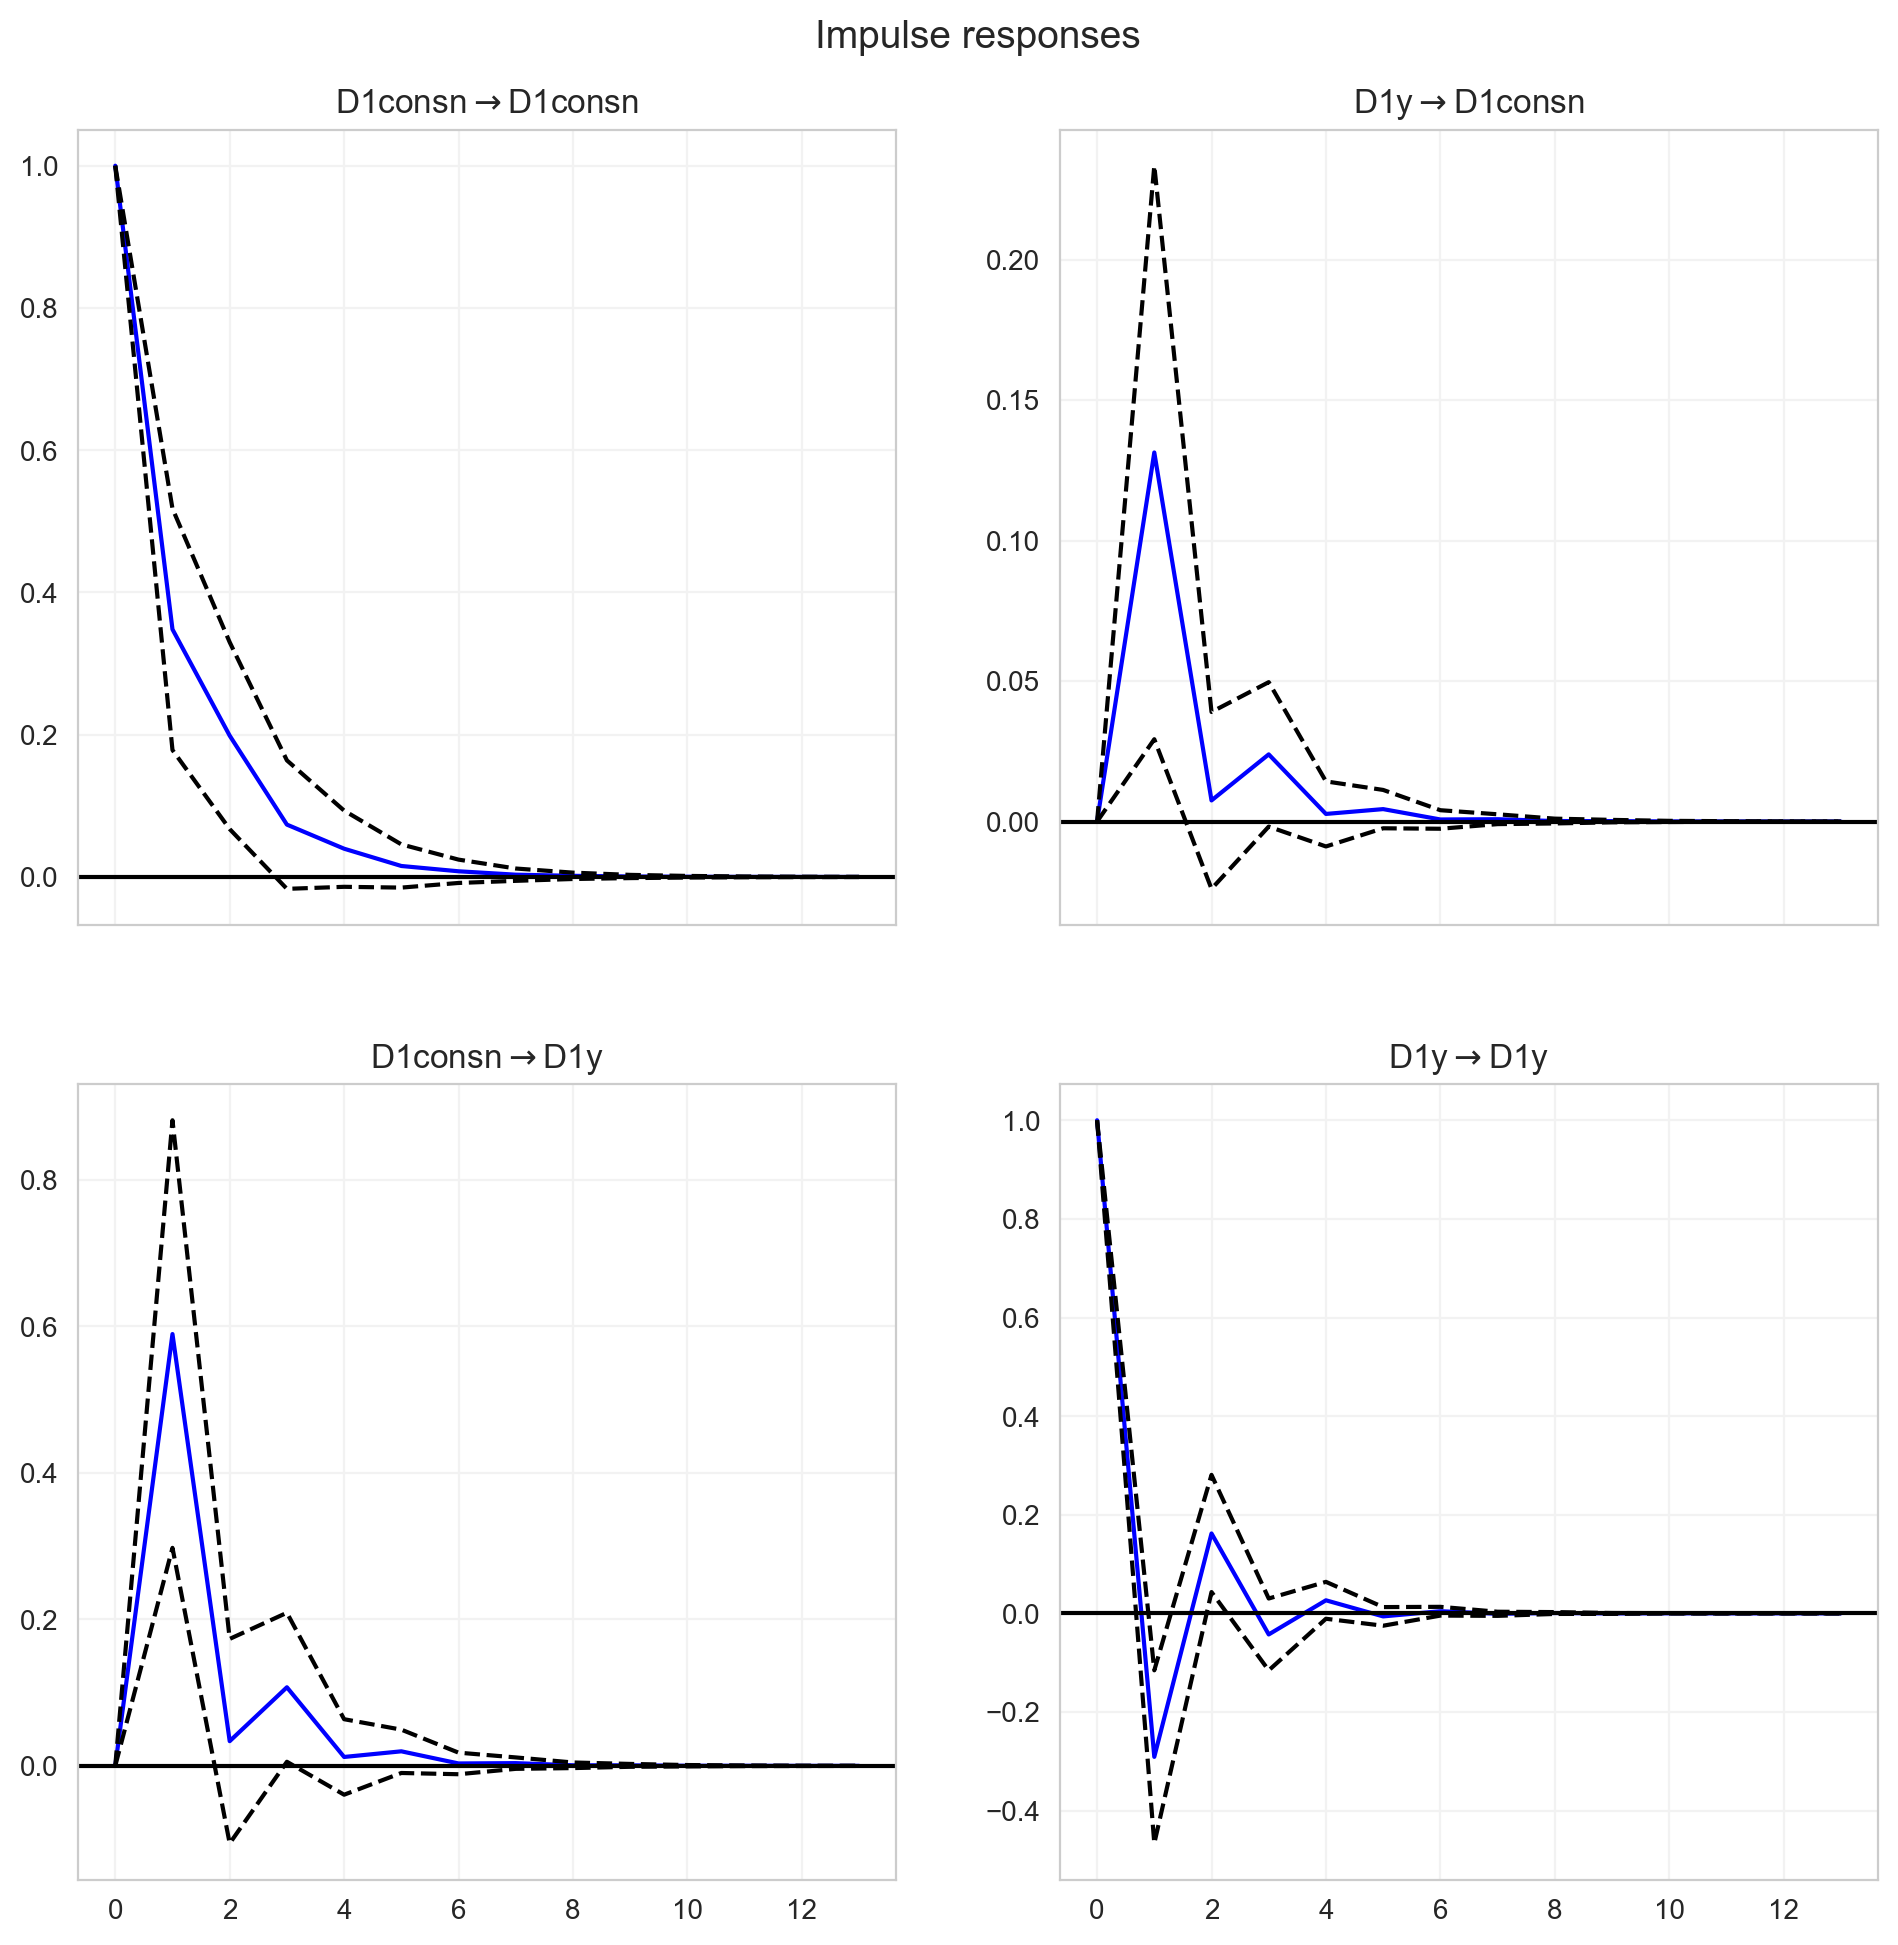

In [28]:
irf=res1.irf(periods=13)
irf_plot=irf.plot(plot_params=[-0.1,1.0])

In [29]:
fevd=res1.fevd(periods=13)
fevd.summary()

FEVD for D1consn
       D1consn       D1y
0     1.000000  0.000000
1     0.960764  0.039236
2     0.961922  0.038078
3     0.960935  0.039065
4     0.960971  0.039029
5     0.960939  0.039061
6     0.960940  0.039060
7     0.960939  0.039061
8     0.960939  0.039061
9     0.960939  0.039061
10    0.960939  0.039061
11    0.960939  0.039061
12    0.960939  0.039061

FEVD for D1y
       D1consn       D1y
0     0.067257  0.932743
1     0.120587  0.879413
2     0.120917  0.879083
3     0.122700  0.877300
4     0.122776  0.877224
5     0.122846  0.877154
6     0.122851  0.877149
7     0.122854  0.877146
8     0.122854  0.877146
9     0.122854  0.877146
10    0.122854  0.877146
11    0.122854  0.877146
12    0.122854  0.877146




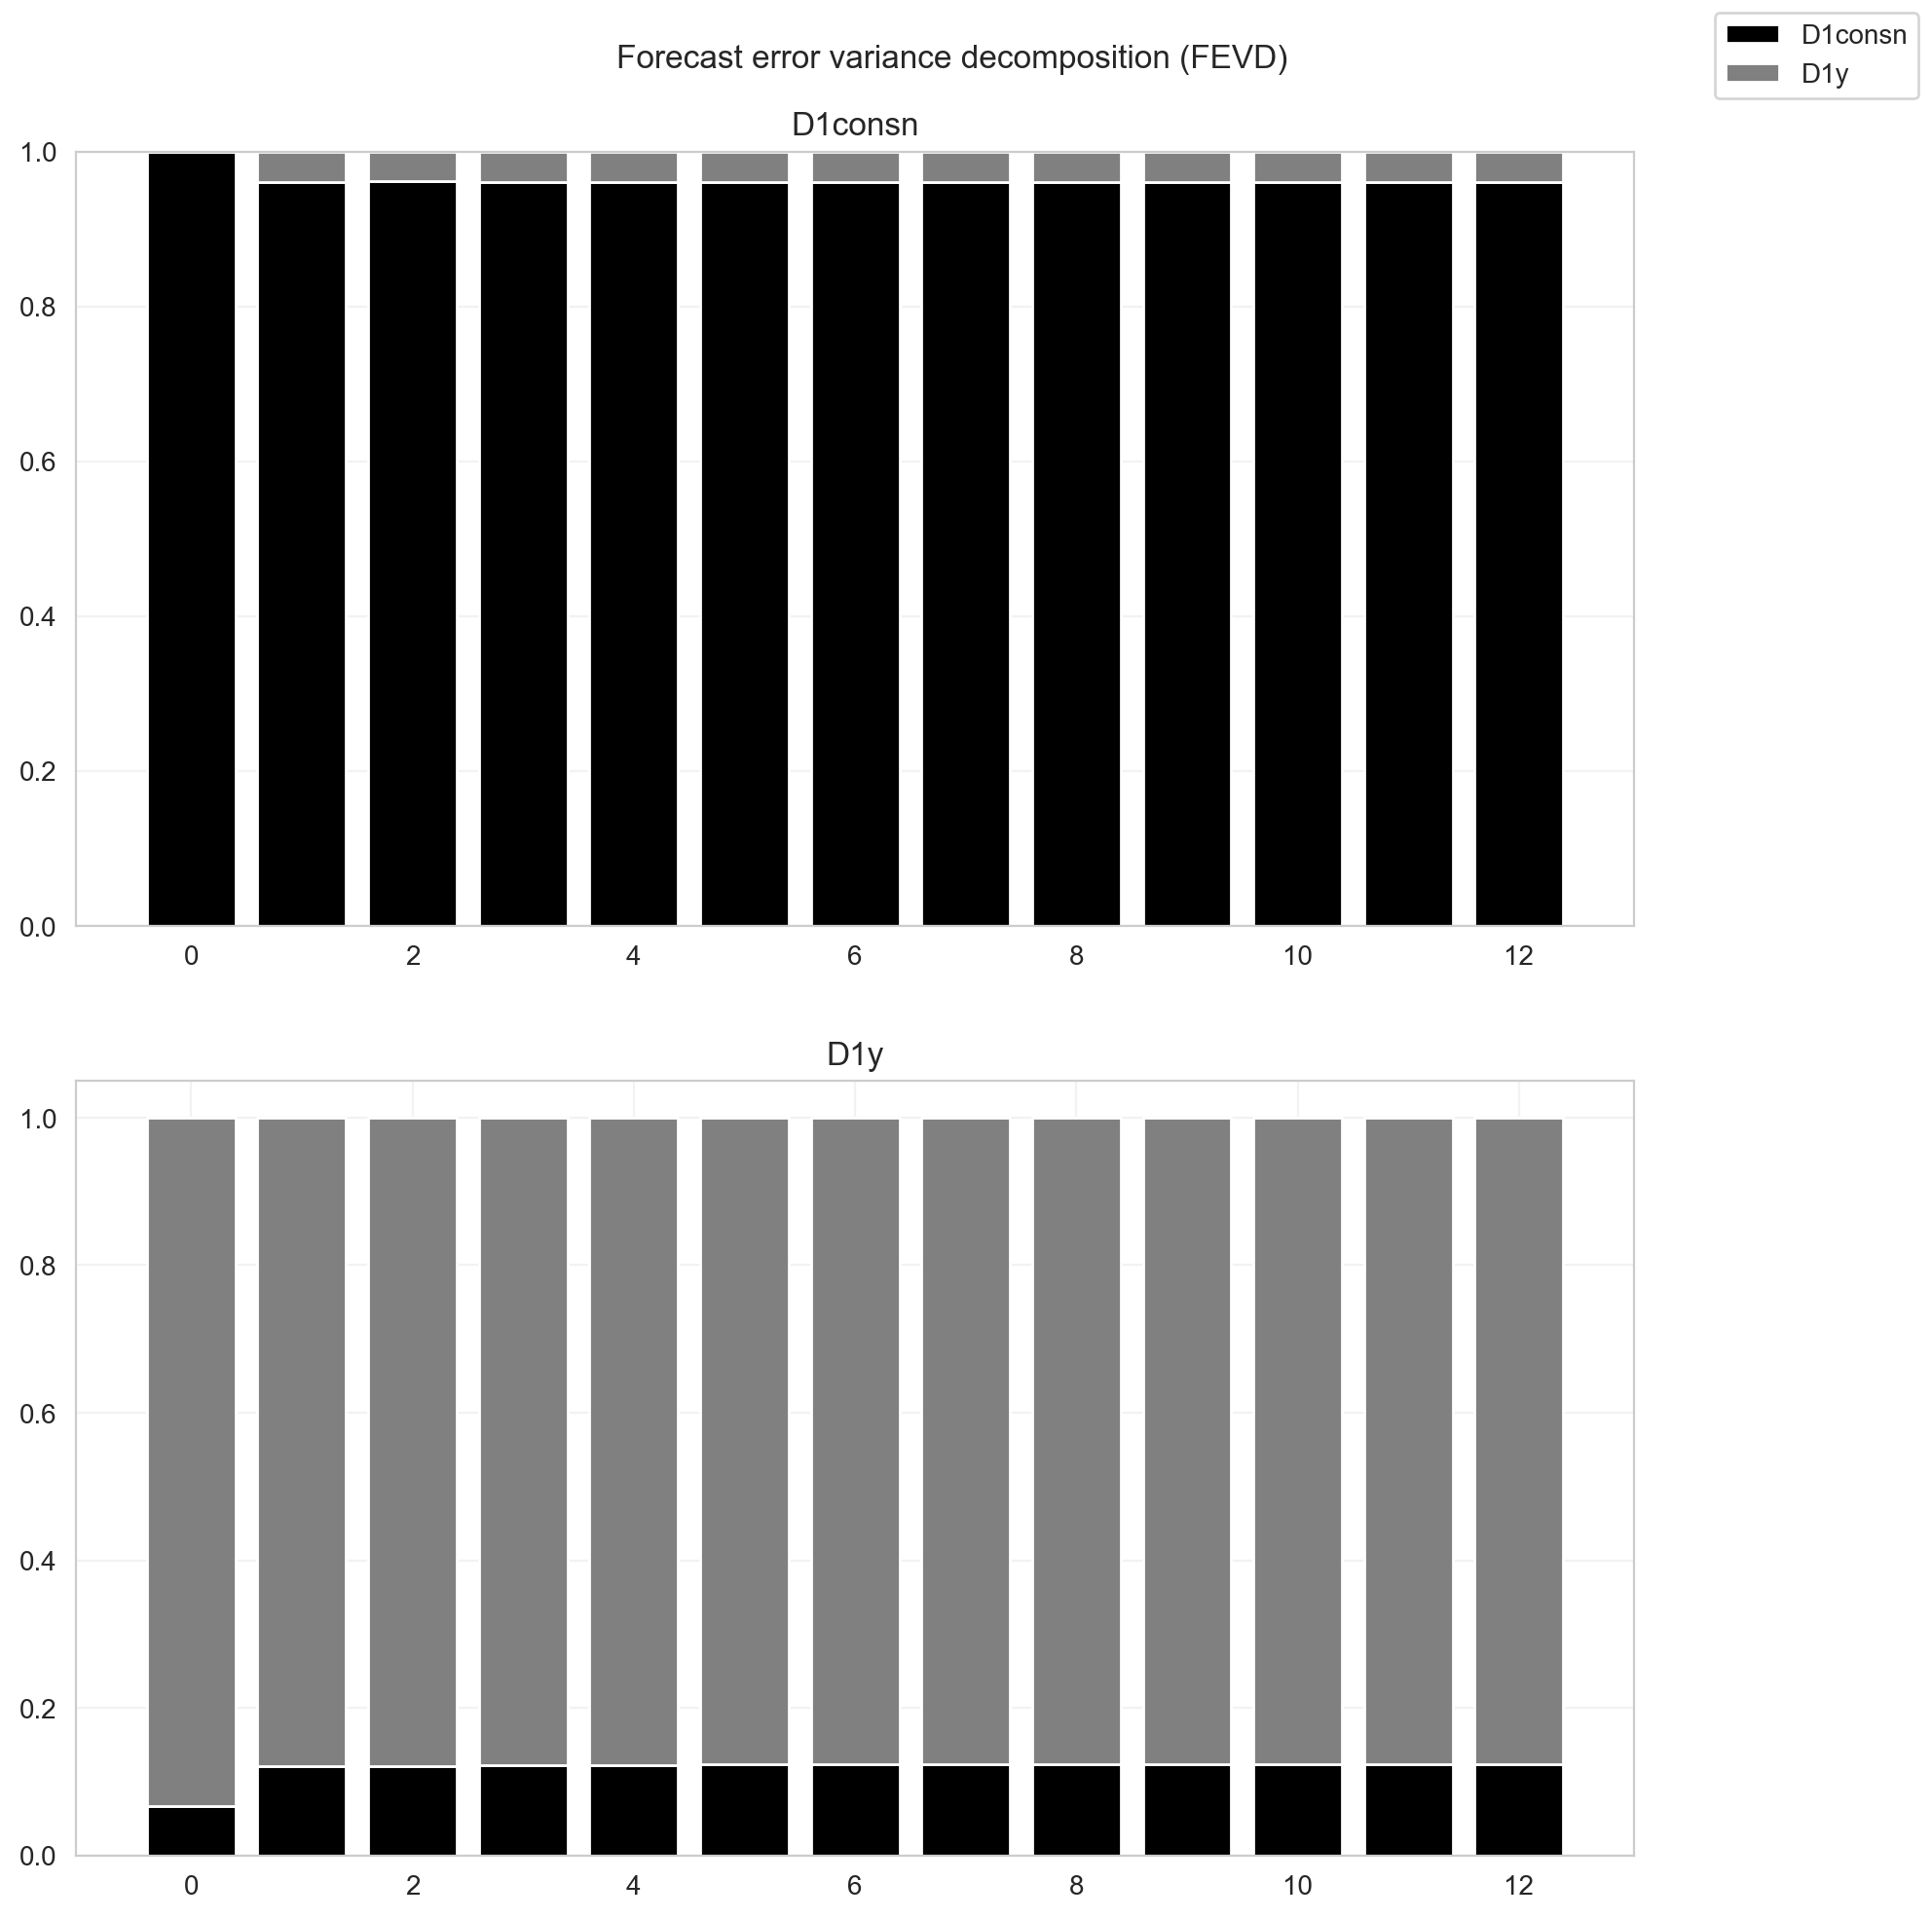

In [30]:
fevd.plot();